Import required packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

## Step 0. Load Images

In [2]:
# Load Calibration Images
cal_images = []
cal_images_f = glob.glob('./camera_cal/calibration*.jpg') # Load 20 given images
for file in cal_images_f:
    cal_images.append(mpimg.imread(file))
    #cal_images.append(cv2.imread(file))

## Step 1. Camera Calibration

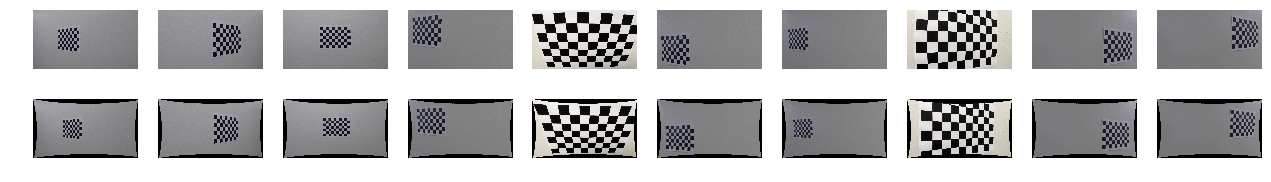

In [3]:
def calibrate_cam(cal_imgs):
    # Arrays to store object and image pts
    nx = 9
    ny = 6
    TestChessDraw = False
    obj_pts = []
    img_pts = []
    # Perpare object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for img in cal_imgs:
        # convert to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        
        #termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        # If corners found, add object points and and image points

        if ret == True:
            obj_pts.append(objp)
            #corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            img_pts.append(corners)

            # Test First Image
            if TestChessDraw == True:
                chess_test_img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
                plt.imshow(chess_test_img)
                TestChessDraw = False
    # Get calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1], None, None)      
    return ret, mtx, dist, rvecs, tvecs
            
# Test calibration
_ , mtx, dist, _ , _ =  calibrate_cam(cal_images)

def undistort(img, mx = mtx , dis = dist):
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mx,dis,(w,h),1,(w,h))
    return cv2.undistort(img, mx, dis, None, newcameramtx)

TestOnChessImages = True
if TestOnChessImages:
    # Check just ten images
    f, axarr = plt.subplots(2, 10, figsize =(22,3))
    for ind, image in enumerate(cal_images):
        axarr[0,ind].imshow(image)
        axarr[1,ind].imshow(undistort(image))
        axarr[0, ind].axis('off')
        axarr[1, ind].axis('off')
        if ind == 9:
            break

## Step 2. Undistort Images

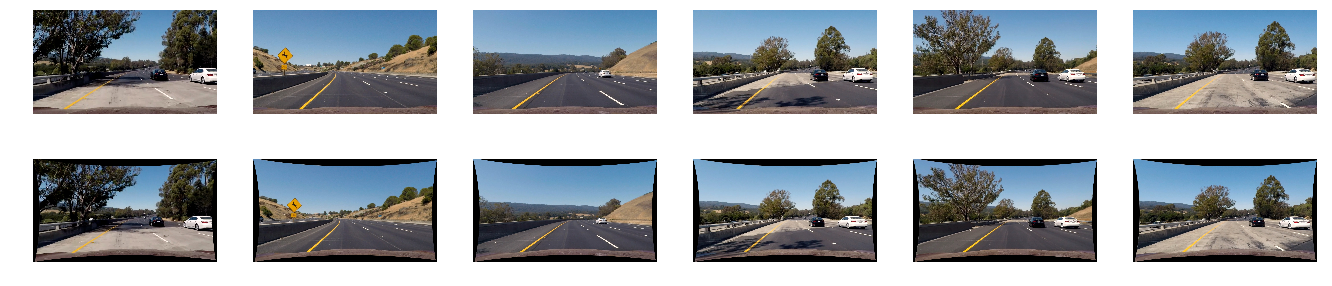

In [4]:
# Load Test Images
test_images = []
test_images_f = glob.glob('./test_images/test*.jpg')
for file in test_images_f:
    test_images.append(mpimg.imread(file))
    
TestOnImages = True
if TestOnImages:
    # Check just ten images
    f, axarr = plt.subplots(2, 6, figsize =(23,5))
    for ind, image in enumerate(test_images):
        axarr[0,ind].imshow(image)
        axarr[1,ind].imshow(undistort(image))
        axarr[0, ind].axis('off')
        axarr[1, ind].axis('off')

    

## Step 3. Color / Gradient Threshold

In [5]:
def hls_select(img, chan = 's', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if chan == 'h':
        channel = hls[:,:,0]
    elif chan == 'l':
        channel = hls[:,:,1]
    elif chan == 's':
        channel = hls[:,:,2]
    hls_binary = np.zeros_like(channel)
    hls_binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return hls_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), convertGray = True):
    # Convert to grayscale
    if convertGray: 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    else:
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), convertGray = True):
    # Convert to grayscale
    if convertGray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), convertGray = True):
    # Grayscale
    if convertGray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    else:
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return dir_binary
        

A. Testing HLS Operators


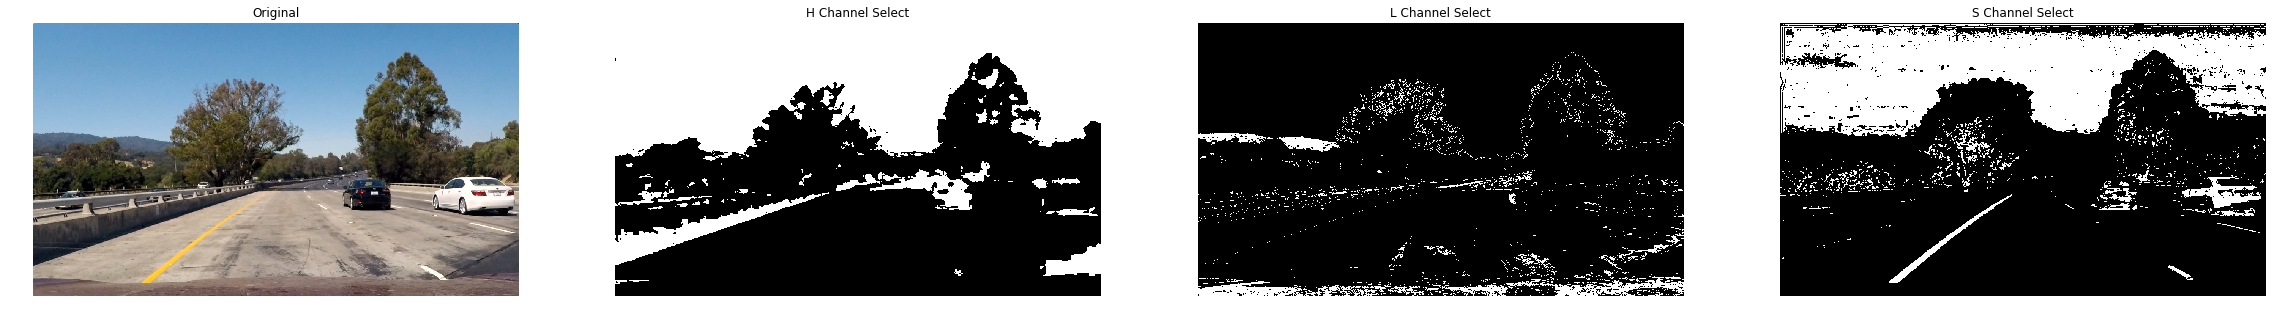

In [6]:
TestOnHLSImages = True
if TestOnHLSImages:

    HLSImages = []
    HLSImages.append(test_images[5])
    HLSImages.append(hls_select(HLSImages[0], chan = 'h', thresh=(100,150)))
    HLSImages.append(hls_select(HLSImages[0], chan = 'l', thresh=(100,120)))
    HLSImages.append(hls_select(HLSImages[0], chan = 's', thresh=(120,255)))
    # Check just ten images
    f, axarr = plt.subplots(1, 4, figsize =(40,10))
    print('A. Testing HLS Operators')
    titles = ['Original', 'H Channel Select', 'L Channel Select', 'S Channel Select']
    for ind, image in enumerate(HLSImages):
        axarr[ind].imshow(image, cmap = 'gray')
        axarr[ind].axis('off')
        axarr[ind].set_title(titles[ind])

B1. Testing Sobel Operators


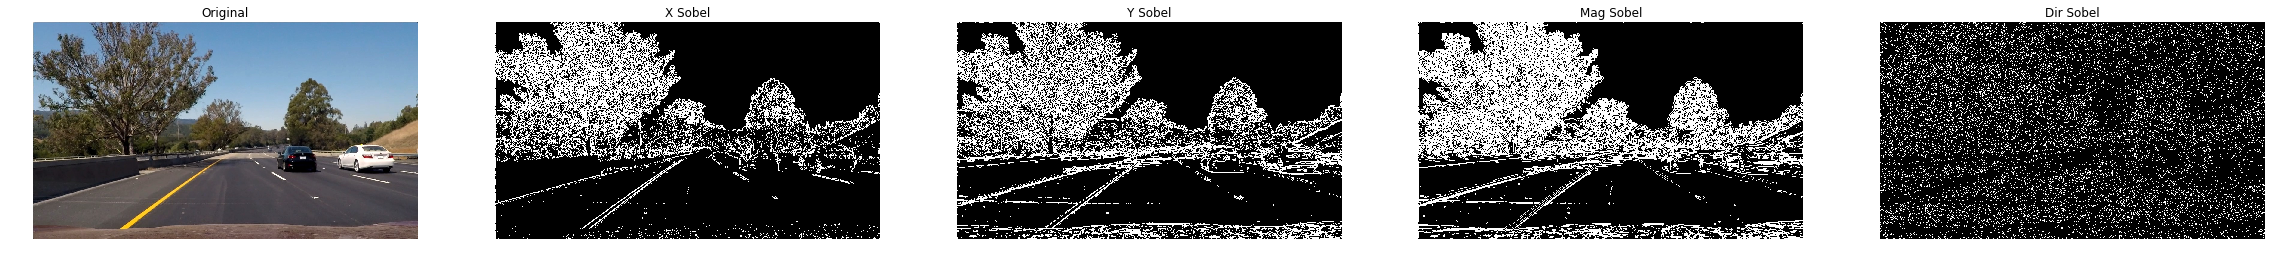

In [7]:
TestOnSobelImages = True
if TestOnSobelImages:
    print('B1. Testing Sobel Operators')
    titles = ['Original', 'X Sobel', 'Y Sobel', 'Mag Sobel', 'Dir Sobel']
    ksize = 7 # Choose a larger odd number to smooth gradient measurements
    SobelImages = []
    SobelImages.append(test_images[4])
    # Apply each of the thresholding functions
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='x', sobel_kernel=ksize, thresh=(10, 100)))
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='y', sobel_kernel=ksize, thresh=(10, 100)))
    SobelImages.append(mag_thresh(SobelImages[0], sobel_kernel=ksize, mag_thresh=(10, 60)))
    SobelImages.append(dir_threshold(SobelImages[0], sobel_kernel=ksize, thresh=(.5, .75)))
    # Check just ten images
    f, axarr = plt.subplots(1, 5, figsize =(40,10))
    for ind, image in enumerate(SobelImages):
        axarr[ind].imshow(image, cmap = 'gray')
        axarr[ind].axis('off')
        axarr[ind].set_title(titles[ind])

B1. Testing Sobel Operators with S channel color threshold


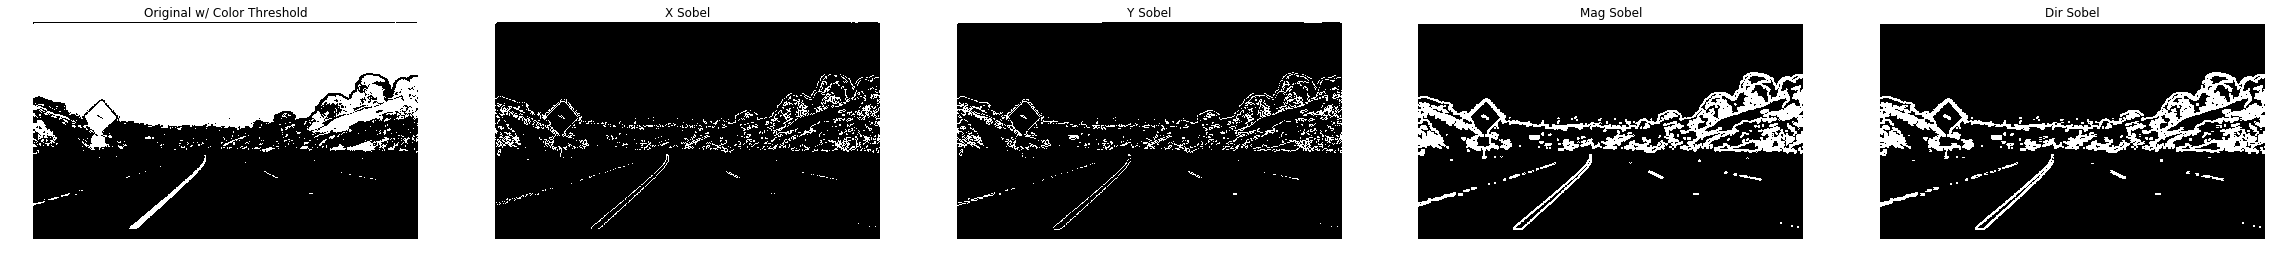

In [8]:
TestOnSobelImages = True
if TestOnSobelImages:
    print('B1. Testing Sobel Operators with S channel color threshold')
    titles = ['Original w/ Color Threshold', 'X Sobel', 'Y Sobel', 'Mag Sobel', 'Dir Sobel']
    ksize = 7 # Choose a larger odd number to smooth gradient measurements
    SobelImages = []
    SobelImages.append(test_images[1])
    SobelImages[0] = hls_select(SobelImages[0], chan = 's', thresh=(80,255))
    # Apply each of the thresholding functions
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='x', sobel_kernel=ksize, thresh=(1, 255), convertGray = False))
    SobelImages.append(abs_sobel_thresh(SobelImages[0], orient='y', sobel_kernel=ksize, thresh=(1, 255), convertGray = False))
    SobelImages.append(mag_thresh(SobelImages[0], sobel_kernel=ksize, mag_thresh=(1, 255), convertGray = False))
    SobelImages.append(dir_threshold(SobelImages[0], sobel_kernel=ksize, thresh=(.01, np.pi/2), convertGray = False))
    # Check just ten images
    f, axarr = plt.subplots(1, 5, figsize =(40,10))
    for ind, image in enumerate(SobelImages):
        axarr[ind].imshow(image, cmap = 'gray')
        axarr[ind].axis('off')
        axarr[ind].set_title(titles[ind])

## Step 4. Perspective Transformation

C. Testing Perspective Transformation


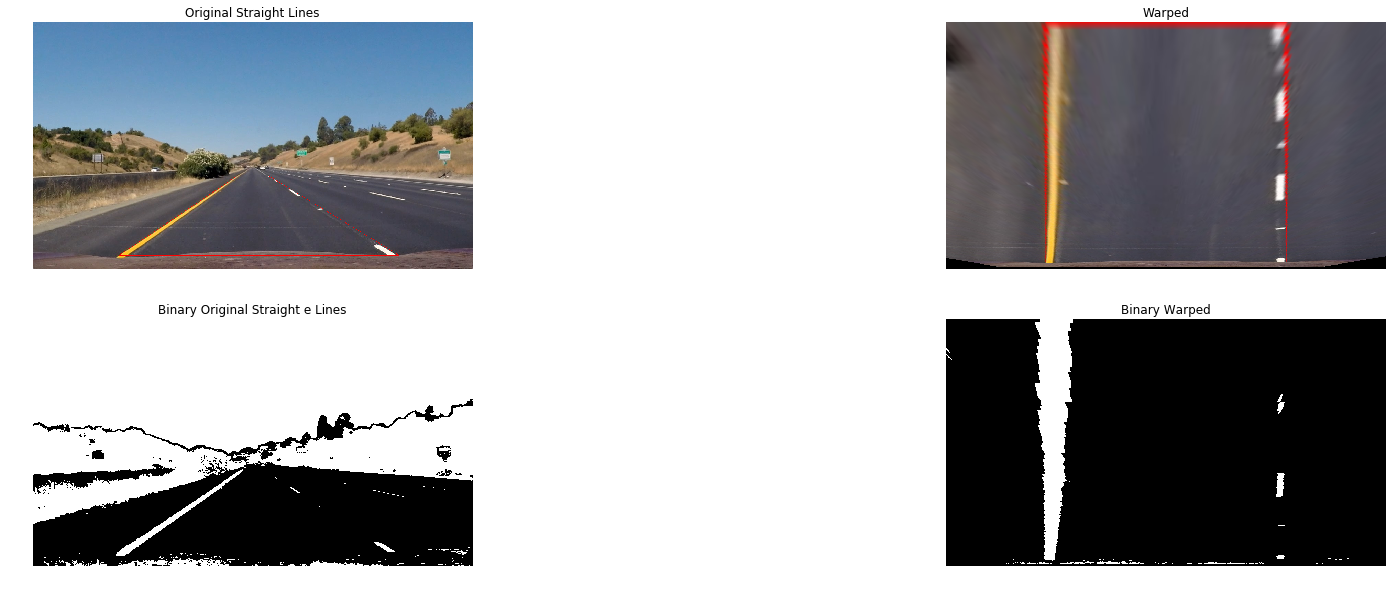

In [9]:
def wrap(img, src_cor, line_length):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    d1 = ((img.shape[1] - line_length)/2, line_length)
    d2 = ((img.shape[1] - line_length)/2, 0)
    d3 = ((img.shape[1] + line_length)/2, 0)
    d4 = ((img.shape[1] + line_length)/2, line_length)
    src = np.array(src_cor, np.float32)
    dst = np.array([d1, d2, d3, d4], np.float32)
    #Calculate the Perspective Transformation Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    # Return the resulting image and matrix
    return warped, M

HLSThresholdL = 40
HLSThresholdH = 255 
warpIMages =[]
warpIMages.append(mpimg.imread('./test_images/straight_lines1.jpg'))
warpIMages.append(hls_select(warpIMages[0], chan = 's', thresh=(HLSThresholdL,HLSThresholdH)))

src_cor = ((250,680),(592,450),(687,450),(1065,680))
line_length = 700
cv2.line(warpIMages[0],src_cor[0],src_cor[1],(255,0,0),1)
cv2.line(warpIMages[0],src_cor[1],src_cor[2],(255,0,0),1)
cv2.line(warpIMages[0],src_cor[2],src_cor[3],(255,0,0),1)
cv2.line(warpIMages[0],src_cor[3],src_cor[0],(255,0,0),1)

print('C. Testing Perspective Transformation')
titles = ['Original Straight Lines','Binary Original Straight e Lines', 'Warped', 'Binary Warped']
wrapedImg, M = wrap(warpIMages[0], src_cor, line_length)
wrapedImgGray, M = wrap(warpIMages[1], src_cor, line_length)
warpIMages.append(wrapedImg)
warpIMages.append(wrapedImgGray)

f, axarr = plt.subplots(2, 2, figsize =(30,10))
indices = ((0,0),(1,0),(0,1),(1,1))
for ind, image in enumerate(warpIMages):
    axarr[indices[ind]].imshow(image, cmap = 'gray')
    axarr[indices[ind]].axis('off')
    axarr[indices[ind]].set_title(titles[ind])

## Step 5. Detect Lane Lines

In [10]:
def findLane(warpedImg, VisualizeHist = True):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warpedImg[int(warpedImg.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warpedImg, warpedImg, warpedImg))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warpedImg.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warpedImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warpedImg.shape[0] - (window+1)*window_height
        win_y_high = warpedImg.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    
    ploty = np.linspace(0, warpedImg.shape[0]-1, warpedImg.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if VisualizeHist:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return out_img, left_fit, right_fit
    
def trackLane(img, left_fit, right_fit, VisualizeTrack = True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if VisualizeTrack:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return result, left_line_pts, right_line_pts

(-0.5, 1279.5, 719.5, -0.5)

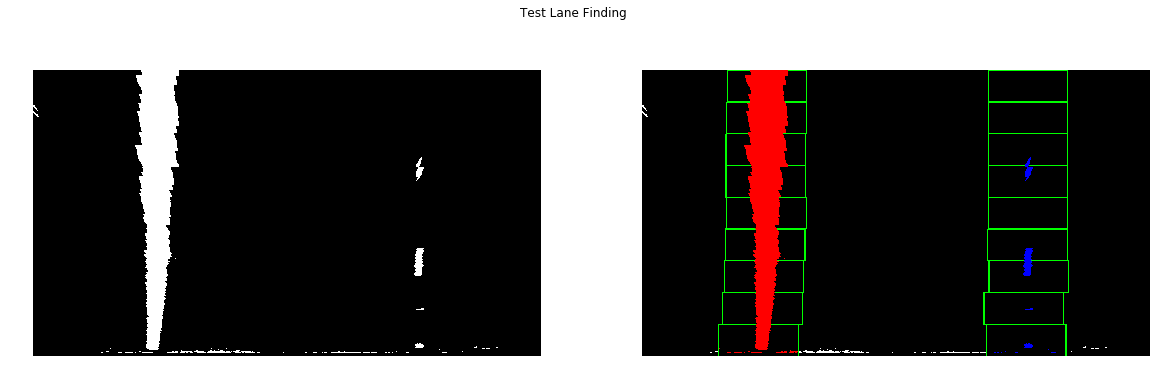

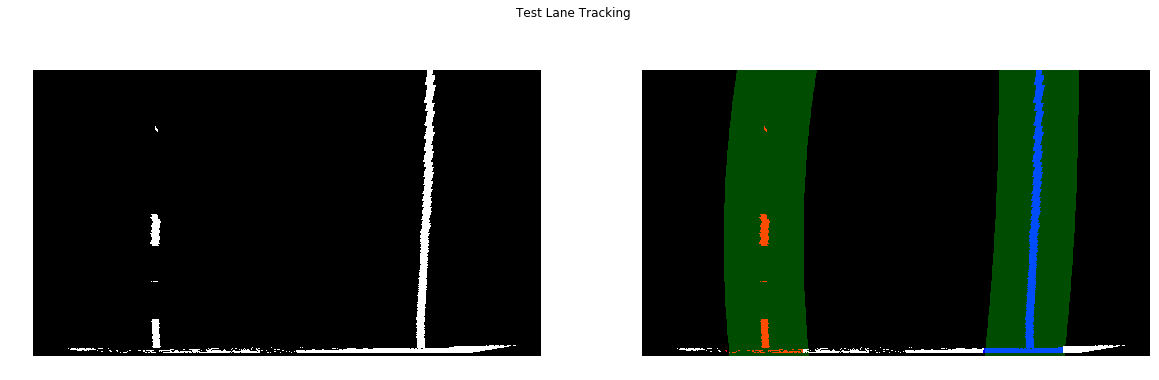

In [11]:
# Test Line Finding
def scale(im):
    rows,cols, ch = im.shape
    rpts = np.random.randint(-3,3)
    pts1 = np.float32([[rpts,rpts],[rows-rpts,rpts],[rpts,cols-rpts],[rows-rpts,cols-rpts]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    im = cv2.warpPerspective(im,M,(rows,cols))
    im = im[:,:,np.newaxis]
    return im
laneTestImage = mpimg.imread('./test_images/straight_lines1.jpg')
laneTestImage = hls_select(laneTestImage, chan = 's', thresh=(HLSThresholdL,HLSThresholdH))
laneTestImage, M = wrap(laneTestImage, src_cor, line_length)
laneImage, left_fit, right_fit = findLane(laneTestImage, False)
fig = plt.figure(figsize=(20, 6)) 
fig.suptitle('Test Lane Finding')
plt.subplot(1,2,1)
plt.imshow(laneTestImage, cmap ='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(laneImage)
plt.axis('off')

trackTestImage = mpimg.imread('./test_images/straight_lines2.jpg')
#Need to change the image a bit - randoml;y scale
#trackTestImage = scale(trackTestImage)
trackTestImage = hls_select(trackTestImage, chan = 's', thresh=(HLSThresholdL,HLSThresholdH))
trackTestImage, M = wrap(trackTestImage, src_cor, line_length)
trackResult, left_line_pts, right_line_pts = trackLane(trackTestImage, left_fit, right_fit, False)
fig = plt.figure(figsize=(20, 6)) 
fig.suptitle('Test Lane Tracking')
plt.subplot(1,2,1)
plt.imshow(trackTestImage, cmap ='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(trackResult)
plt.axis('off')

## Step 6. Determine the Lane Curvature

In [57]:
def findCurve(img, left_line_pts, right_line_pts):
    ploty = np.linspace(0, img.shape[0] - 1, num = img.shape[0])
    left_fit = np.polyfit(ploty, left_line_pts, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, right_line_pts, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images

In [58]:
findCurve(trackTestImage, left_line_pts, right_line_pts)

TypeError: expected 1D or 2D array for y